In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from geopy.distance import geodesic
from pykalman import KalmanFilter
import numpy as np


In [11]:
def charger_donnees(nomcsv, nomtel):
    """Charge les données des fichiers CSV."""
    try:
        gps_data = pd.read_csv(f'results/acquisitionsGPS/{nomcsv}.csv')
        tel_data = pd.read_csv(f'results/acquisitionsTELEPHONE/CSV/{nomtel}.csv')
        return gps_data, tel_data
    except FileNotFoundError as e:
        print(f"Erreur : fichier non trouvé - {e}")
    except pd.errors.EmptyDataError:
        print("Erreur : un des fichiers CSV est vide.")
    except pd.errors.ParserError:
        print("Erreur : problème de format dans un fichier CSV.")
    return None, None

convert_time = lambda x: datetime.strptime(x, "%Y/%m/%d - %H:%M:%S").strftime("%Y-%m-%dT%H:%M:%SZ")

def fusionner_donnees(gps_data, tel_data):
    """Fusionne les données GPS et téléphone sur la colonne UTC."""
    return pd.merge_asof(
        gps_data.sort_values('UTC'),
        tel_data.sort_values('UTC'),
        on='UTC', suffixes=('_GPS', '_Tel')
    ).dropna()

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calcule la distance haversine entre deux points GPS."""
    return geodesic((lat1, lon1), (lat2, lon2)).meters

def calculer_erreurs(merged_df):
    """Ajoute une colonne de distance et affiche les statistiques d'erreur."""
    merged_df['distance'] = merged_df.apply(lambda row: haversine_distance(
        row['Latitude_GPS'], row['Longitude_GPS'], row['Latitude_Tel'], row['Longitude_Tel']), axis=1)
    print(f"Erreur moyenne : {merged_df['distance'].mean():.2f} mètres")
    print(f"Erreur max : {merged_df['distance'].max():.2f} mètres")
    print(f"Erreur min : {merged_df['distance'].min():.2f} mètres")
    return merged_df

def creer_dossier_sauvegarde(nomresult):
    """Crée un dossier de sauvegarde pour les résultats."""
    output_folder = f'traitements/{nomresult}'
    os.makedirs(output_folder, exist_ok=True)
    return output_folder

def calculer_chemin_moyen(merged_df):
    merged_df['Latitude_corrigée'] = merged_df[['Latitude_GPS', 'Latitude_Tel']].mean(axis=1)
    merged_df['Longitude_corrigée'] = merged_df[['Longitude_GPS', 'Longitude_Tel']].mean(axis=1)

def generer_graphiques(merged_df, output_folder):
    """Génère et sauvegarde différents graphiques de comparaison."""
    plt.figure(figsize=(8, 6))
    plt.scatter(merged_df['Longitude_GPS'], merged_df['Latitude_GPS'], label='GPS', alpha=0.6, marker='x')
    plt.scatter(merged_df['Longitude_Tel'], merged_df['Latitude_Tel'], label='Tel', alpha=0.6, marker='x')
    plt.scatter(merged_df['Longitude_corrigée'], merged_df['Latitude_corrigée'], label='Moyen', alpha=0.6, marker='x')
    plt.legend()
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Comparaison des trajets GPS')
    plt.savefig(f'{output_folder}/comparaison_trajets.png')
    plt.show()

    plt.figure()
    plt.plot(merged_df['distance'], label='Distance GPS - Tel')
    plt.xlabel('Index')
    plt.ylabel('Distance (mètres)')
    plt.title("Évolution de l'erreur")
    plt.legend()
    plt.savefig(f'{output_folder}/erreur_evolution.png')
    plt.show()

    plt.figure()
    plt.plot(merged_df['Latitude_GPS'], label='Latitude GPS')
    plt.plot(merged_df['Latitude_Tel'], label='Latitude Tel')
    plt.legend()
    plt.savefig(f'{output_folder}/comparaison_latitude.png')
    plt.show()

    plt.figure()
    plt.plot(merged_df['Longitude_GPS'], label='Longitude GPS')
    plt.plot(merged_df['Longitude_Tel'], label='Longitude Tel')
    plt.legend()
    plt.savefig(f'{output_folder}/comparaison_longitude.png')
    plt.show()

def sauvegarder_resultats(merged_df, output_folder):
    """Sauvegarde les résultats dans un fichier CSV."""
    output_file = f'{output_folder}/results.csv'
    merged_df.to_csv(output_file, index=False)
    print(f"Résultats sauvegardés dans : {output_file}")

def traitement(nomcsv, nomtel, nomresult):
    """Orchestre le traitement complet des fichiers."""
    gps_data, tel_data = charger_donnees(nomcsv, nomtel)
    if gps_data is None or tel_data is None:
        return

    gps_data['UTC'] = pd.to_datetime(gps_data['UTC'].apply(convert_time), errors='coerce')
    tel_data['UTC'] = pd.to_datetime(tel_data['UTC'], errors='coerce')

    merged_df = fusionner_donnees(gps_data, tel_data)
    merged_df = calculer_erreurs(merged_df)

    calculer_chemin_moyen(merged_df)

    output_folder = creer_dossier_sauvegarde(nomresult)
    generer_graphiques(merged_df, output_folder)
    sauvegarder_resultats(merged_df, output_folder)


Erreur moyenne : 19.51 mètres
Erreur max : 68.54 mètres
Erreur min : 0.43 mètres


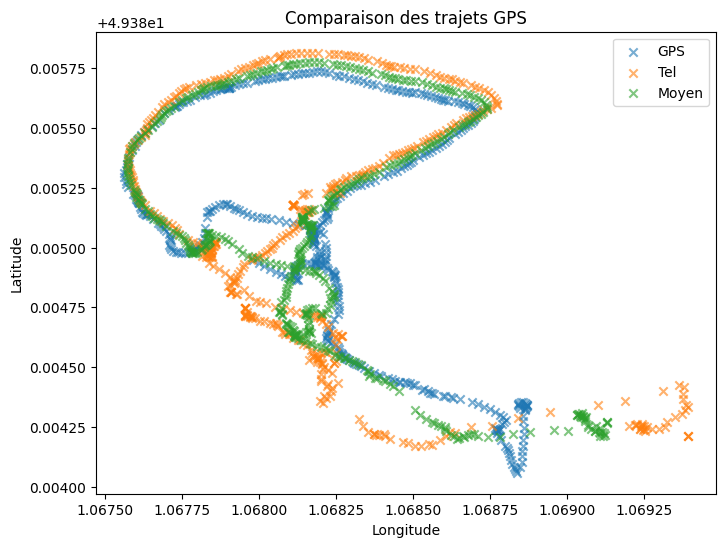

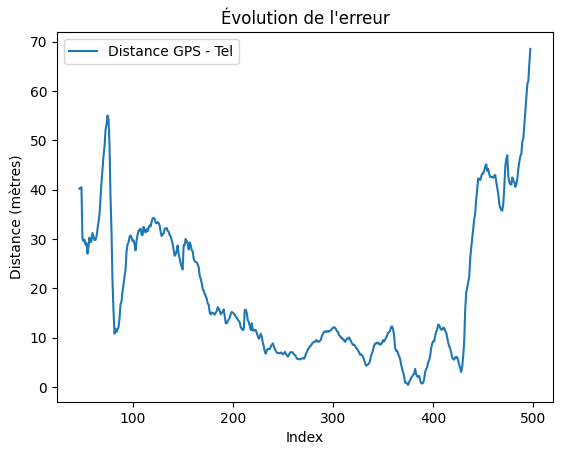

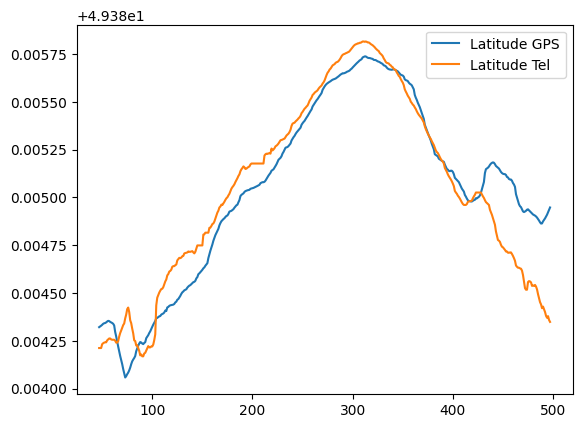

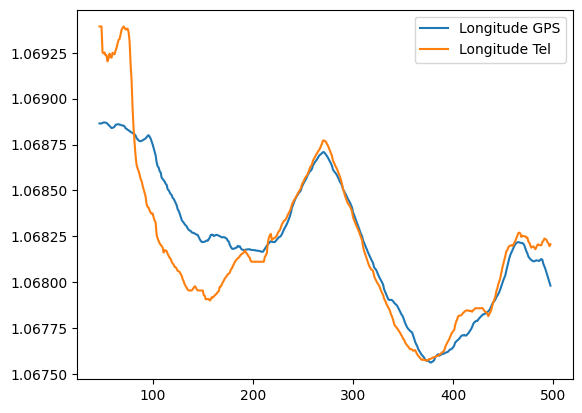

Résultats sauvegardés dans : traitements/gps1/results.csv
Erreur moyenne : 5.67 mètres
Erreur max : 5.86 mètres
Erreur min : 5.47 mètres


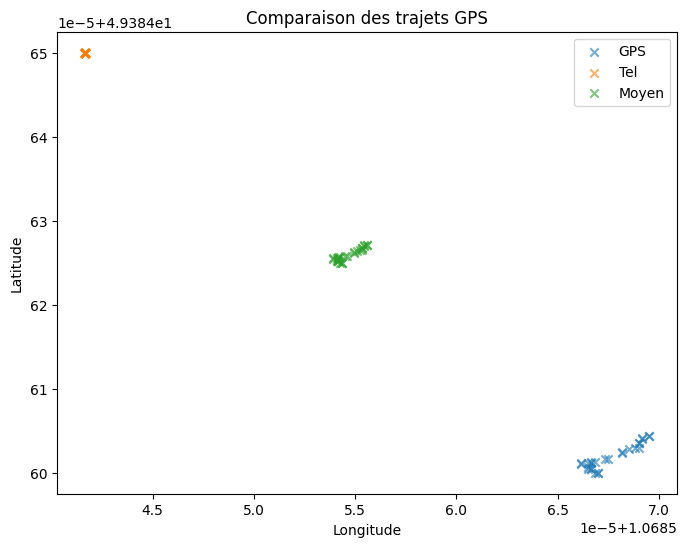

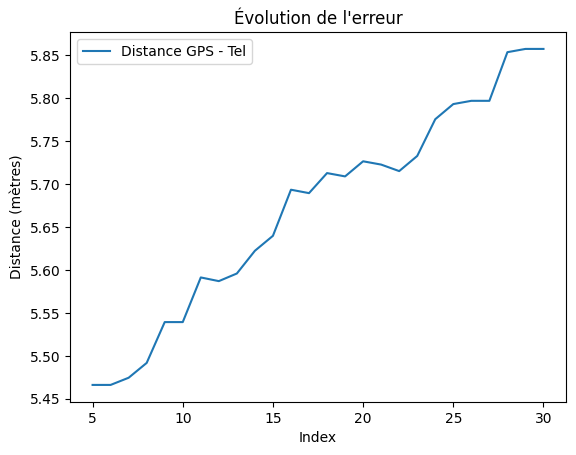

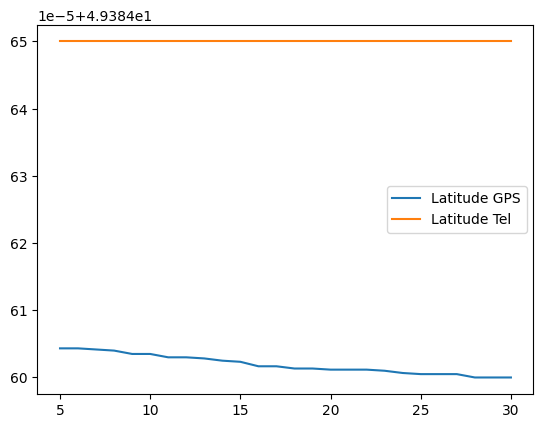

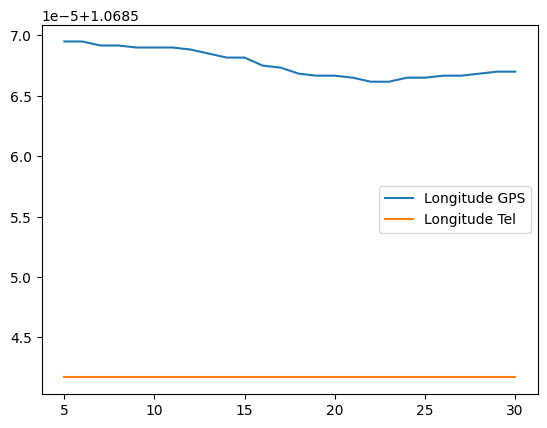

Résultats sauvegardés dans : traitements/immobile1/results.csv
Erreur moyenne : 13.27 mètres
Erreur max : 33.24 mètres
Erreur min : 1.17 mètres


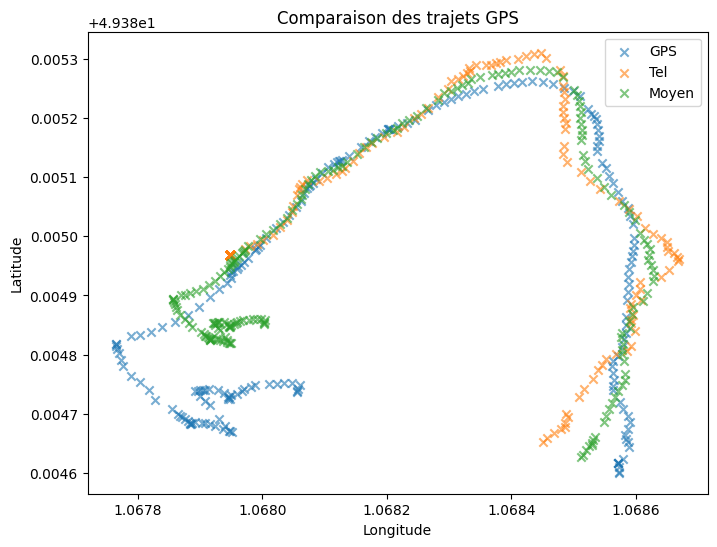

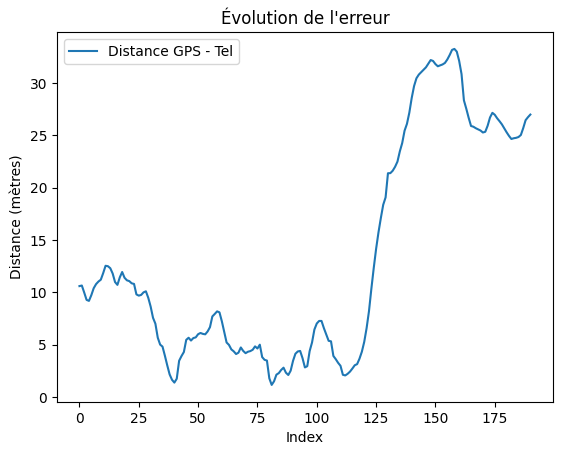

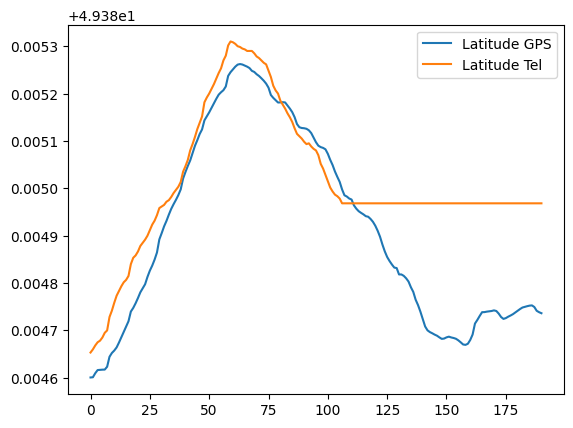

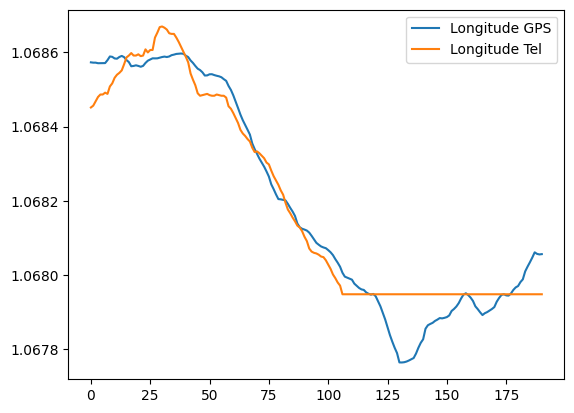

Résultats sauvegardés dans : traitements/tour_magellan1/results.csv


In [12]:
traite = {"gps1":("gps1","acquisition1"),
          "immobile1":("immobile_1","Immobile_1"),
          "tour_magellan1":("tour_magellan_1","PointeMagellan")}

for itineraire in traite:
    traitement(traite[itineraire][0],traite[itineraire][1],itineraire)